In [15]:
import json
import numpy as np
import matplotlib.pyplot as plt
import os


# Replace with the actual paths to your JSON files
json_paths = [os.path.join(os.path.dirname(os.getcwd()), 'log_dir/scaling_factor_0.1_v3/eval_student_model_urma.json'),
              os.path.join(os.path.dirname(os.getcwd()), 'log_dir/scaling_factor_0.5_v3_modelscale3_attempt2/eval_student_model_urma.json')]
labels = ['scaling_factor_0.1_v3',
          'scaling_factor_0.5_v3_modelscale3_attempt2']

# Function to read JSON files and load dictionaries
def load_dicts_from_json(paths):
    data_dicts = []
    for path in paths:
        with open(path, "r") as f:
            data_dicts.append(json.load(f))
    return data_dicts

# Function to calculate means and standard deviations
def calculate_stats(data_dicts):
    means = []
    stds = []
    for data in data_dicts:
        values = [v["average_return"] for v in data.values()]
        means.append(np.mean(values))
        stds.append(np.std(values))
    return means, stds

# Load data from JSON files
data_dicts = load_dicts_from_json(json_paths)

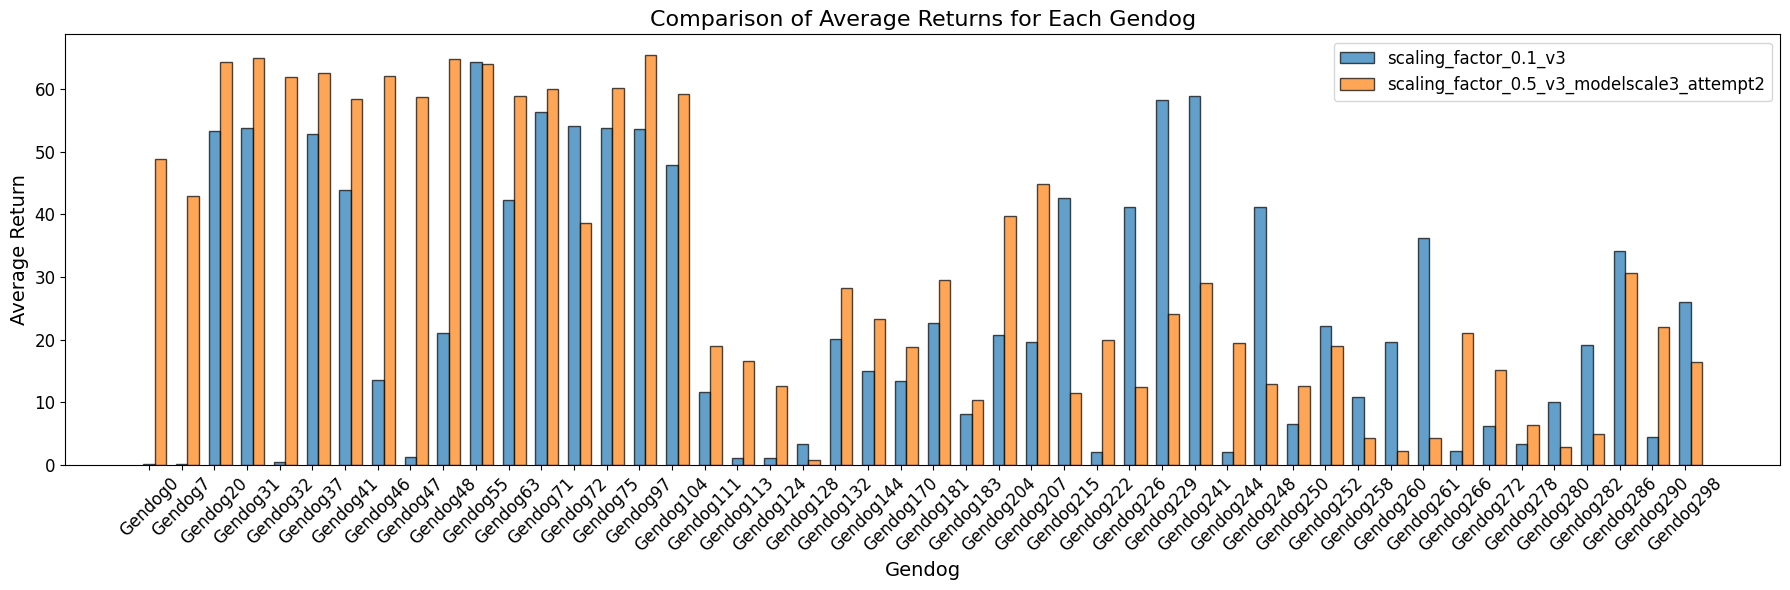

In [30]:
def sort_gendog_keys(data_dict):
    return sorted(data_dict.keys(), key=lambda x: int(x.replace("Gendog", "")))

# Create the plot
plt.figure(figsize=(18, 6))

for i, data_dict in enumerate(data_dicts):
    # Extract Gendogs and their average returns
    sorted_gendogs = sort_gendog_keys(data_dict)
    rewards = [data_dict[gendog]['average_return'] for gendog in sorted_gendogs]

    # X positions for the bars
    x = np.arange(len(sorted_gendogs))  # The label locations
    width = 0.35  # Width of the bars

    plt.bar(x + 2*i*width/len(data_dicts), rewards, width, label=labels[i], alpha=0.7, edgecolor='black')

# Add titles and labels
plt.title("Comparison of Average Returns for Each Gendog", fontsize=16)
plt.xlabel("Gendog", fontsize=14)
plt.ylabel("Average Return", fontsize=14)
plt.xticks(x, sorted_gendogs, fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)

# Display the plot
plt.tight_layout()
plt.show()

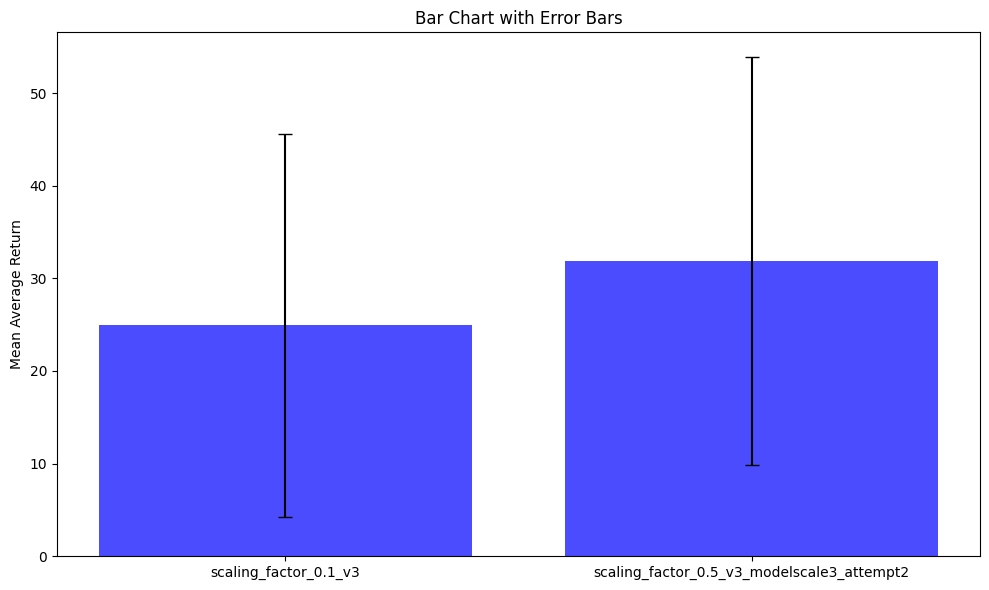

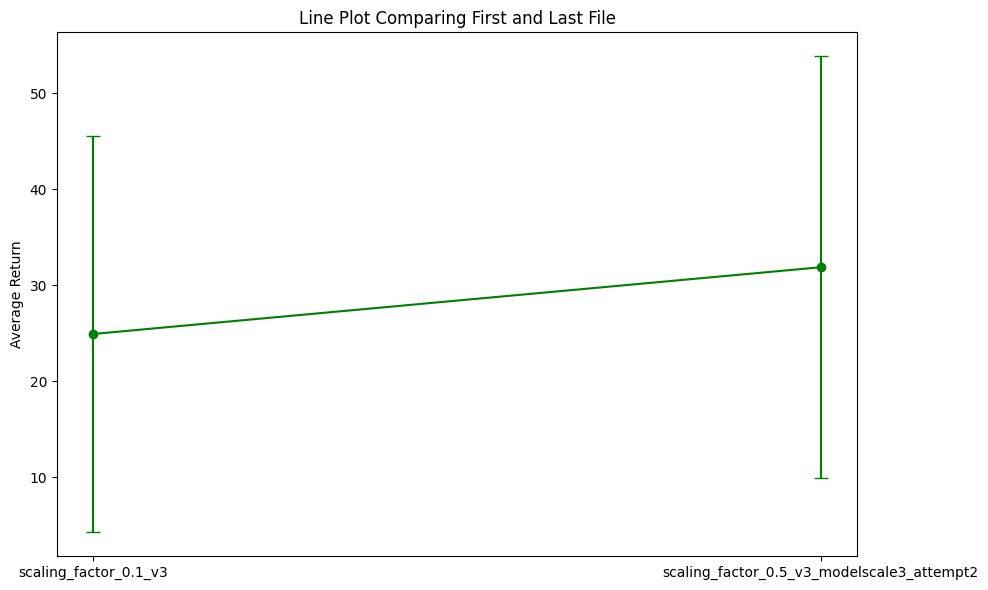

In [18]:
# Calculate statistics for bar chart
means, stds = calculate_stats(data_dicts)

# Plot bar chart with error bars
plt.figure(figsize=(10, 6))
x_labels = labels
plt.bar(x_labels, means, yerr=stds, capsize=5, alpha=0.7, color='blue')
plt.ylabel("Mean Average Return")
plt.title("Bar Chart with Error Bars")
plt.tight_layout()
plt.show()

# Plot line plot with error bars comparing first and last files
if len(data_dicts) >= 2:
    first_values = [v["average_return"] for v in data_dicts[0].values()]
    last_values = [v["average_return"] for v in data_dicts[-1].values()]

    first_mean, last_mean = np.mean(first_values), np.mean(last_values)
    first_std, last_std = np.std(first_values), np.std(last_values)

    plt.figure(figsize=(10, 6))
    plt.errorbar(labels, [first_mean, last_mean], yerr=[first_std, last_std], fmt='-o', capsize=5, color='green')
    plt.ylabel("Average Return")
    plt.title("Line Plot Comparing First and Last File")
    plt.tight_layout()
    plt.show()
else:
    print("At least two JSON files are required for the line plot comparison.")


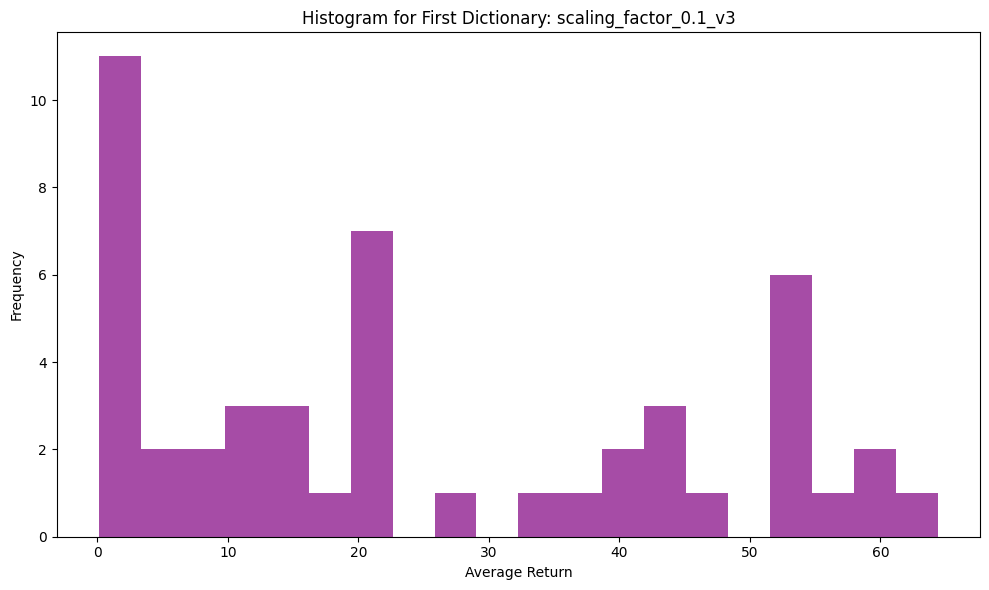

In [21]:
# Plot histogram for a specific dictionary
def plot_histogram(data_dict, title="Histogram of Average Returns"):
    values = [v["average_return"] for v in data_dict.values()]
    plt.figure(figsize=(10, 6))
    plt.hist(values, bins=20, color='purple', alpha=0.7)
    plt.xlabel("Average Return")
    plt.ylabel("Frequency")
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Example usage for the first dictionary
if data_dicts:
    plot_histogram(data_dicts[0], title="Histogram for First Dictionary: "+labels[0])


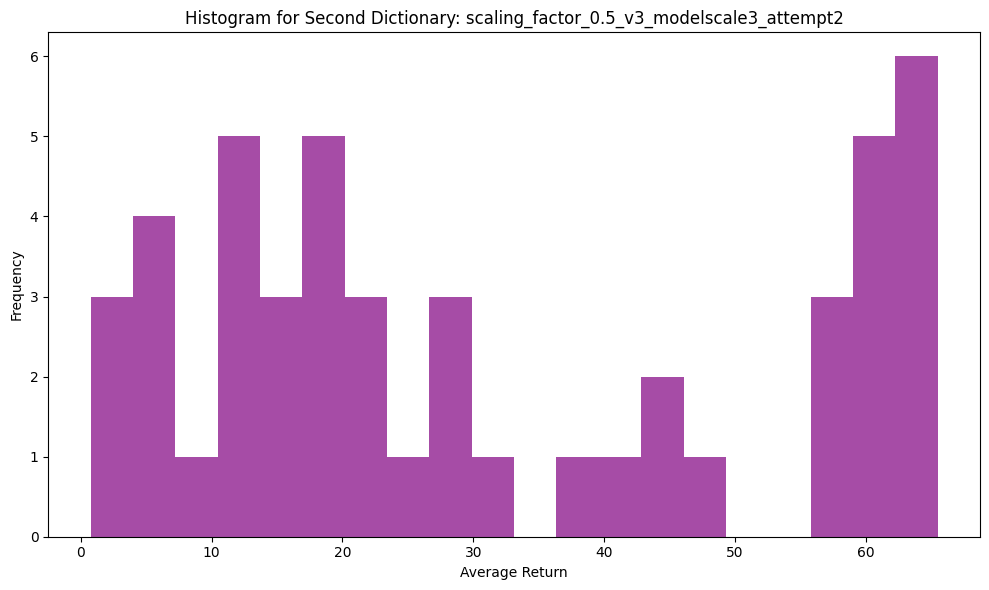

In [22]:
# Plot histogram for a specific dictionary
def plot_histogram(data_dict, title="Histogram of Average Returns"):
    values = [v["average_return"] for v in data_dict.values()]
    plt.figure(figsize=(10, 6))
    plt.hist(values, bins=20, color='purple', alpha=0.7)
    plt.xlabel("Average Return")
    plt.ylabel("Frequency")
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Example usage for the first dictionary
if data_dicts:
    plot_histogram(data_dicts[1], title="Histogram for Second Dictionary: "+labels[1])
